<a href="https://colab.research.google.com/github/niklasfaller/DIS21-BIg-Data/blob/main/Ex4_Classifying_newswires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200">

# 4th exercise: <font color="#C70039">Multi-Class classification of newswires</font>
* Course: DIS21a.1
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook modifications and adaptations: Niklas Faller
* Date: 08.01.2024

<img src="https://miro.medium.com/max/700/1*HgXA9v1EsqlrRDaC_iORhQ.png" style="float: center;" width="400">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information about your tasks (e.g. regarding the set of certain paramaters or specific computational tricks, etc.), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation (for instance, after you have run through your test plan) you may use German language.
This applies to all exercises in DIS 21a.1.  

--------------------

### <font color="ce33ff">DESCRIPTION</font>:
The previous exercises were dealing with classification problems, that was to classify data into two mutually exclusive classes using a densely-connected neural network. In this exercise you will deal with a problem where you have more than two classes.

This notebook allows you for classifying Reuters newswires into 46 different mutually-exclusive topics (multi-class classification problem), and since each data point should be classified into only one category, the problem is more specifically spoken a "single-label, multi-class classification" problem (compare lecture slide p.163).
If each data point could have belonged to multiple categories (in our case the topics) then we would be facing a "multi-label, multi-class classification" problem.

The example works with the so-called _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It is a very simple, widely used toy data set for text classification. There are 46 different topics. Some topics are more represented than others, but each topic has got at least 10 examples in the training set. Like IMDB and MNIST, the Reuters data set comes packaged as part of Keras.

-----------------------

### <font color="FFC300">TASKS</font>:
Within this notebook, the tasks that you need to work on are always listed as bullet points below.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook before submitting it.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully.
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time and note the result in your markdown result table (your test plan).
4. decode the newswire back to english words by what you have learned from the previous exercise.
5. go into the section 'building the ANN'.
    * add the missing code that does create a network as shown in the image in the lecture slides on page 172 (File: 'DIS21a.1-7.HANDS_ON.First.DLNetwork.Architectures.for.Solving.Three.Interesting.Problems.pdf')
    * set the activation function to ReLu
    * set the correct activation function in the last layer/the output. What is correct when doing a single-label, multi-class classification?
    * add the missing code for compiling the network by setting
        * the loss function
        * the optimizer
        * an evaluation metric, that makes sense
6. optimize the hyperparameters, build a new model and evaluate it on the test data.
    * determine the minimum number of epochs and train a new model from scratch for this number of epochs.
    * evaluate it on the test set from the data set you have loaded.
7. make combinations of this according to your test plan. Make sure you combine with sense and reason and not just chaotically.
    * Try using smaller or larger layers: 32 units, 128 units...
    * We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.
8. comment your observations.
    * when is the accuracy increasing/decreasing? Describe your findings!

## START OF THE NOTEBOOK CODE
----------------------------------------------------------------------------------------------------------------------

In [2]:
import tensorflow
#tensorflow.keras.__version__

### loading the reuters newswire data set

In [3]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


Like with the IMDB data set, the argument `num_words=10000` restricts the data to the 10.000 most frequently occurring words found in the data.

There are 8.982 training examples and 2.246 test examples.

In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices).

In [6]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

#### <font color="#00ff00">Task 4:</font> decode one entry back to words

In [7]:
word_index = reuters.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[10]])


550378/550378 [==============================] - 0s 0us/step


In [8]:
decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

The label associated with an example is an integer between 0 and 45, since there are 46 topics: a topic index

In [9]:
train_labels[10]

3

### data preparation

The data is going to be vectorized with the exact same code as in the previous exercise.

In [10]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, one-hot-encoding is used, since it is a widely used format for categorical data, very often also referred to as "categorical encoding".

Here, one-hot encoding of the labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index.

In [11]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

<font color=red>Note</font> that there is a more elegant and built-in way to do this in Keras, which you have already seen in action in the MNIST example:

In [12]:
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### building the ANN

This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger.

#### <font color ="#00ff00">Task 5:</font> build and compile the ANN
as described in the task list

In [13]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(64, activation = 'relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(46, activation = 'softmax'))
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])




### Validating the ANN model

Let's set apart 1000 samples from the training data to use as a validation set. The testing data remains untouched.

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train the ANN for 20 epochs with batch_size=512 and use the history object.

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 105ms/step - loss: 2.9496 - accuracy: 0.4826 - val_loss: 1.9841 - val_accuracy: 0.6080
Epoch 2/20
16/16 [==============================] - 1s 64ms/step - loss: 1.6552 - accuracy: 0.6763 - val_loss: 1.4377 - val_accuracy: 0.6890
Epoch 3/20
16/16 [==============================] - 1s 59ms/step - loss: 1.2545 - accuracy: 0.7387 - val_loss: 1.2172 - val_accuracy: 0.7320
Epoch 4/20
16/16 [==============================] - 1s 52ms/step - loss: 1.0169 - accuracy: 0.7846 - val_loss: 1.1039 - val_accuracy: 0.7680
Epoch 5/20
16/16 [==============================] - 1s 61ms/step - loss: 0.8410 - accuracy: 0.8224 - val_loss: 1.0039 - val_accuracy: 0.7830
Epoch 6/20
16/16 [==============================] - 1s 54ms/step - loss: 0.6997 - accuracy: 0.8530 - val_loss: 0.9558 - val_accuracy: 0.8040
Epoch 7/20
16/16 [==============================] - 1s 74ms/step - loss: 0.5842 - accuracy: 0.8768 - val_loss: 0.9319 - val_accuracy: 0.7930
Epoch 8/20
1

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Visualize the loss and accuracy by using pyplot.

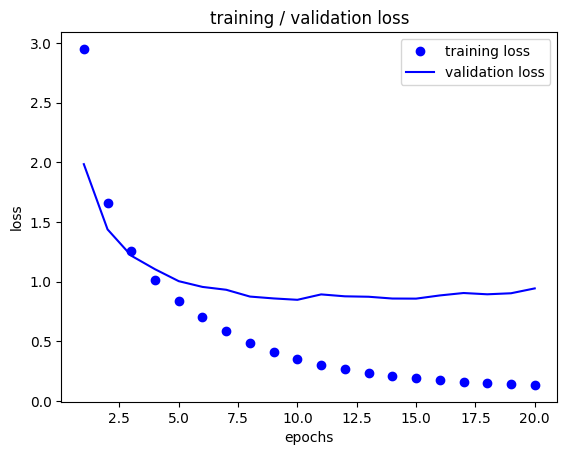

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

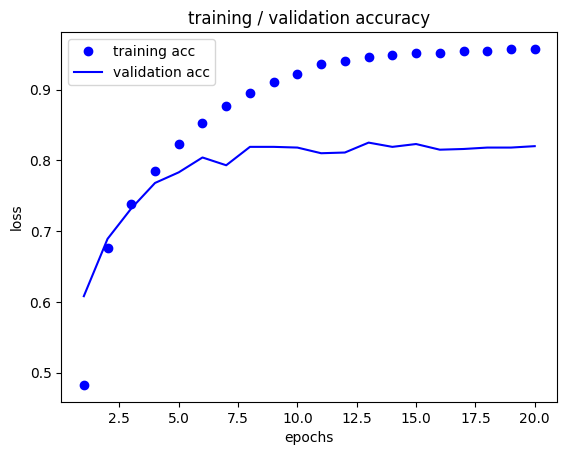

In [18]:
plt.clf()   # clear the old figure (if you forget it, this might cause problems sometimes.)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training / validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

As you can see the ANN starts overfitting after some epochs.

#### <font color ="#00ff00">Task 6:</font> Optimize the hyperparameters, build a new model and evaluate it on the test data
1. determine the minimum number of epochs and train a new model from scratch for this number of epochs
    * set all missing hyperparameters and other parameters that are needed
2. evaluate it on the test set

In [35]:
model = models.Sequential()

#add your parameters here
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

#add your parameters here
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#add your parameters here
model.fit(partial_x_train,
          partial_y_train,
          epochs=4,
          batch_size=128,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/4
63/63 [==============================] - 2s 27ms/step - loss: 1.8600 - accuracy: 0.6317 - val_loss: 1.2183 - val_accuracy: 0.7250
Epoch 2/4
63/63 [==============================] - 1s 22ms/step - loss: 0.9852 - accuracy: 0.7801 - val_loss: 1.0025 - val_accuracy: 0.7860
Epoch 3/4
63/63 [==============================] - 1s 22ms/step - loss: 0.6779 - accuracy: 0.8538 - val_loss: 0.9170 - val_accuracy: 0.8110
Epoch 4/4
71/71 [==============================] - 1s 7ms/step - loss: 0.9888 - accuracy: 0.7809


In [36]:
results

[0.9887981414794922, 0.7809438705444336]

The approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, so your results seem pretty good, at least when compared to a random baseline.

In [37]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.195013357079252

### <font color="#C70039">Include your result table here and reflect a good test plan (see task list)</font>

7. make combinations of this according to your test plan. Make sure you combine with sense and reason and not just chaotically.

In [39]:
model = models.Sequential()

#add your parameters here
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))

model.add(layers.Dense(46, activation='softmax'))

#add your parameters here
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#add your parameters here
model.fit(partial_x_train,
          partial_y_train,
          epochs= 4,
          batch_size= 128,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)
print(results)

Epoch 1/4
63/63 [==============================] - 2s 28ms/step - loss: 1.9045 - accuracy: 0.6381 - val_loss: 1.2229 - val_accuracy: 0.7240
Epoch 2/4
63/63 [==============================] - 2s 25ms/step - loss: 0.9645 - accuracy: 0.7934 - val_loss: 0.9746 - val_accuracy: 0.7990
Epoch 3/4
63/63 [==============================] - 2s 27ms/step - loss: 0.6690 - accuracy: 0.8643 - val_loss: 0.8666 - val_accuracy: 0.8140
Epoch 4/4
71/71 [==============================] - 0s 5ms/step - loss: 0.8780 - accuracy: 0.8028
[0.8780397772789001, 0.8027604818344116]


In [40]:
model = models.Sequential()

#add your parameters here
model.add(layers.Dense(46, activation='softmax', input_shape=(10000,)))


#add your parameters here
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#add your parameters here
model.fit(partial_x_train,
          partial_y_train,
          epochs= 4,
          batch_size= 128,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)
print(results)

Epoch 1/4
63/63 [==============================] - 2s 18ms/step - loss: 2.5476 - accuracy: 0.5782 - val_loss: 1.9148 - val_accuracy: 0.6430
Epoch 2/4
63/63 [==============================] - 1s 14ms/step - loss: 1.5420 - accuracy: 0.6999 - val_loss: 1.4191 - val_accuracy: 0.7020
Epoch 3/4
63/63 [==============================] - 1s 15ms/step - loss: 1.1267 - accuracy: 0.7617 - val_loss: 1.1848 - val_accuracy: 0.7380
Epoch 4/4
71/71 [==============================] - 0s 6ms/step - loss: 1.1280 - accuracy: 0.7493
[1.1280241012573242, 0.7493321299552917]


In [41]:
model = models.Sequential()

#add your parameters here

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

#add your parameters here
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#add your parameters here
model.fit(partial_x_train,
          partial_y_train,
          epochs=4,
          batch_size=128,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/4
63/63 [==============================] - 2s 28ms/step - loss: 1.9539 - accuracy: 0.5874 - val_loss: 1.3108 - val_accuracy: 0.7010
Epoch 2/4
63/63 [==============================] - 1s 18ms/step - loss: 1.0904 - accuracy: 0.7502 - val_loss: 1.0764 - val_accuracy: 0.7570
Epoch 3/4
63/63 [==============================] - 1s 20ms/step - loss: 0.7768 - accuracy: 0.8230 - val_loss: 0.9805 - val_accuracy: 0.7940
Epoch 4/4
71/71 [==============================] - 0s 4ms/step - loss: 1.0332 - accuracy: 0.7769


In [43]:
model = models.Sequential()

#add your parameters here

model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

#add your parameters here
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#add your parameters here
model.fit(partial_x_train,
          partial_y_train,
          epochs=4,
          batch_size=128,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/4
63/63 [==============================] - 2s 29ms/step - loss: 2.1694 - accuracy: 0.5432 - val_loss: 1.4609 - val_accuracy: 0.6650
Epoch 2/4
63/63 [==============================] - 1s 19ms/step - loss: 1.2400 - accuracy: 0.7270 - val_loss: 1.1779 - val_accuracy: 0.7490
Epoch 3/4
63/63 [==============================] - 1s 23ms/step - loss: 0.9345 - accuracy: 0.8037 - val_loss: 1.0269 - val_accuracy: 0.7870
Epoch 4/4
71/71 [==============================] - 0s 4ms/step - loss: 1.0369 - accuracy: 0.7698


| epoch | batch sitze | layer | units | method | loss function | optimizer | accuracy |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|4 | 128 | 3 | 64/64/46 | classification | categorical_crossentropy | rsmprop |.7809
|4 | 128 | 2 | 64/46 | classification | categorical_crossentropy | rsmprop |.8028
|4 | 128 | 1 | 46 | classification | categorical_crossentropy | rsmprop |.7493
|8 | 128 | 2 | 64/46 | classification | categorical_crossentropy | rsmprop |.7996
|4 | 128 | 3 | 32/32/46 | classification | categorical_crossentropy | rsmprop |.7698


### generating predictions on new data

The `predict` method of your model returns a probability distribution over all 46 topics (which sums to 1).
Now, generate topic predictions for all of the test data.

In [44]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


Each entry in predictions is a vector of length 46.

In [45]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1.

In [46]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability.

In [47]:
np.argmax(predictions[0])

3